In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
from scipy.integrate import trapz
from matplotlib import pyplot as plt
import abstractions as abs
import pandas as pd

plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1

In [22]:
sim_kwargs = {
    "delt": 15,
    "simLength": 96 * 60 * 60,
    "Tout" : 288.15,
    "radG": 400,
    "Tfloor": None,
}
wall_kwargs = {
    "X": 9,
    "Y": 10,
}

room_kwargs = {
    "T0": 293.15,
    "V" : 2880, #volume of air
    "Eint" : 250 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP1",
    "alphas": None,
    "As": None,
    "Ls": None
}

connectivityMatrix = np.array([
    [3],
])

roomList = [
    ("R", {}), #room
    ]


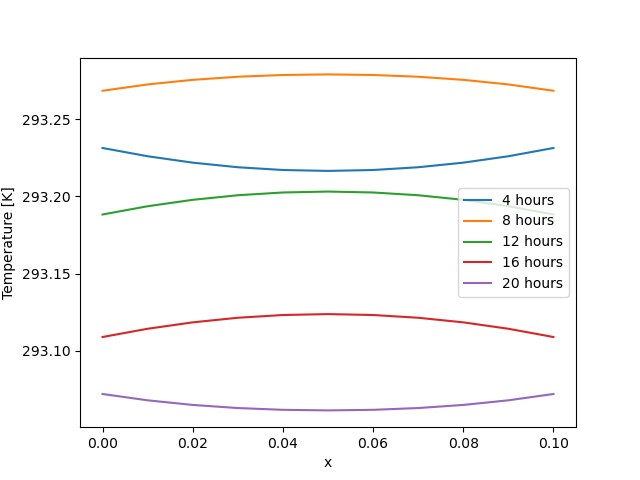

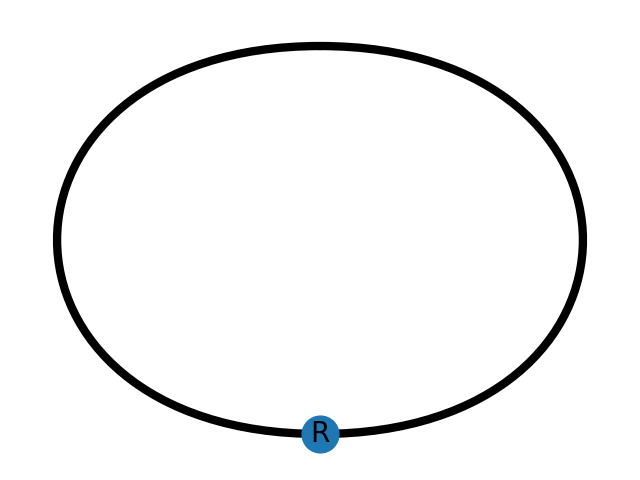

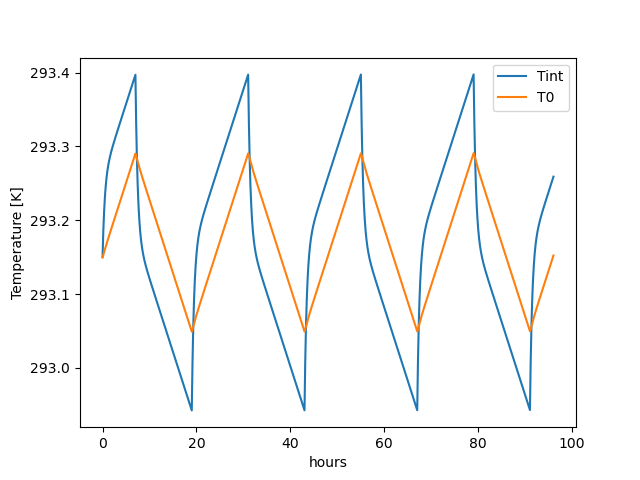

In [23]:

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })
bG.draw()

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
# h_profs = [0, *h_profs]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

### Roof Instead of Walls


In [24]:
roomListOut = [
    ("R", {}), #room
    ("RF", {}),# outside
    ]

connectivityMatrixOut = np.array([
    [0 , 3],
    [3 , 0],
])



#### No Solar Radiation

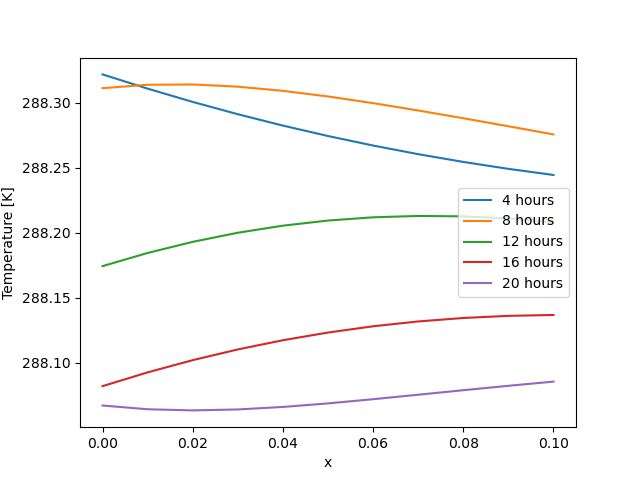

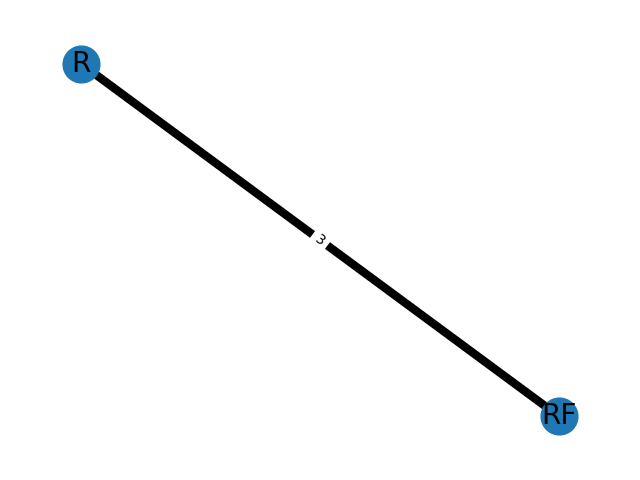

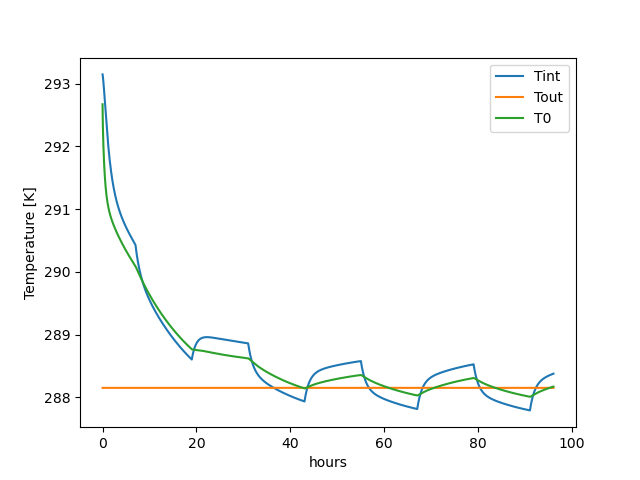

In [25]:

bG = abs.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })
bG.draw()


build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
Touts = build_sim.bG.G.nodes['RF']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']


# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, Touts, label='Tout')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

#### Solar Radiation

Text(0, 0.5, 'Radiation [W]')

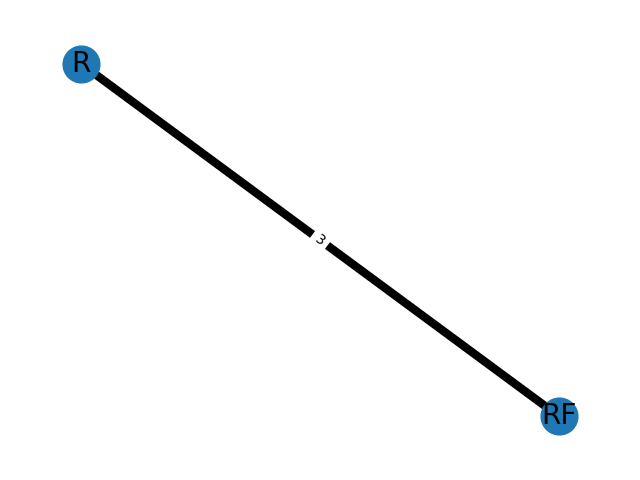

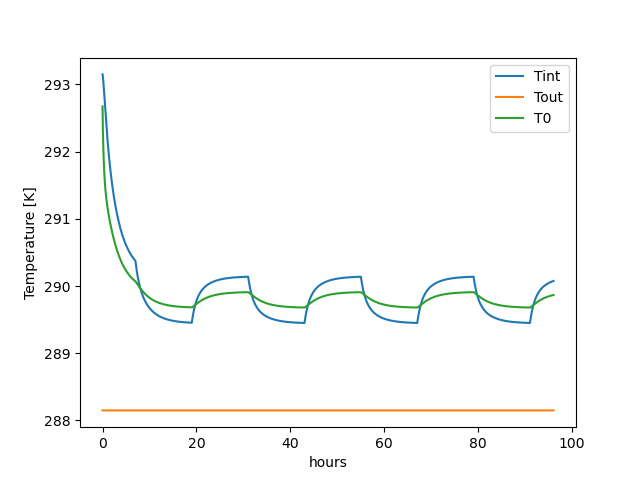

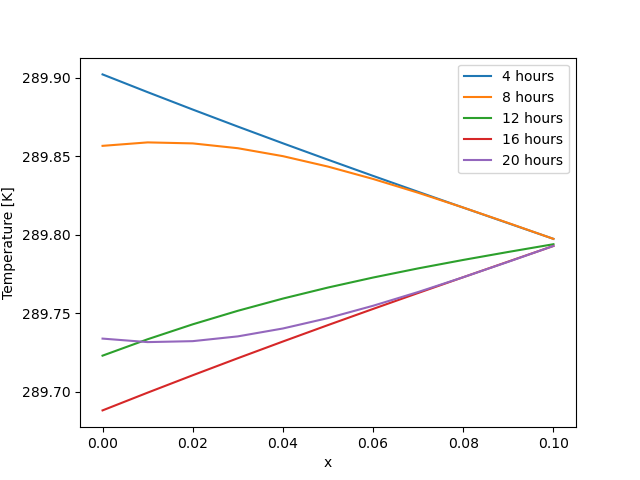

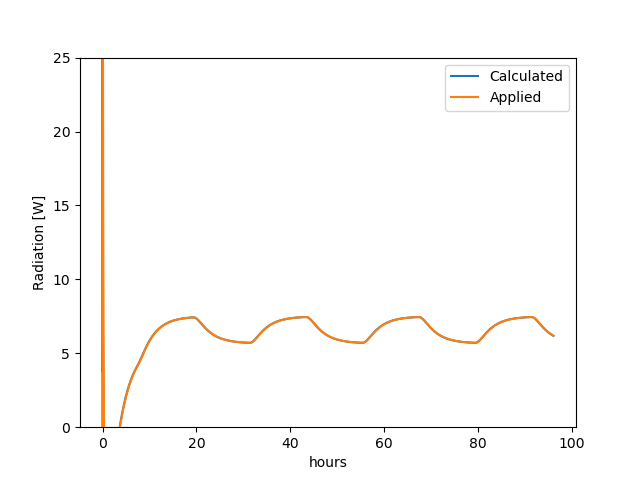

In [26]:
rad_kwargs_RF = {
    "bG": abs.BuildingGraph(
        np.array([
            [0, -1],
            [-1, 0],
        ]),
        [
            ("sun", {}), 
            ("R", {}),
        ]
    ),
}

bG = abs.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])
bG.draw()


build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
Touts = build_sim.bG.G.nodes['RF']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']


# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, Touts, label='Tout')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].back, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].back, label='Applied')
plt.legend()
plt.ylim([0, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

## Problem 4

In [27]:
# Window dimmensions
H = 1
W = 1

# Load data
JW = sp.io.loadmat('JulyWeek.mat')
alphas = [42, 42, 42]
As = [1.61, 1.755, 1.755]
Ls = [11.34, 6.62, 2.07]

Q4 = sp.io.loadmat('./Q4data.mat')

Real_Tint = Q4['TintMeas'].flatten() + 273.15

T_start = Real_Tint[0]

hours = Q4['time'].flatten()
times = hours * 60 * 60
Tints[0] = T_start
Touts = Q4['Tout'].flatten() + 273.15

In [28]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : Touts,
    "radG": 500,
    "Tfloor": None,
} 
wall_kwargs = {
    "X": 9,
    "Y": 10,
}

room_kwargs = {
    "T0": T_start,
    "V" : 2880, #volume of air
    "Eint" : 250 #internal heat generation
}

vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP4",
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}


Text(0, 0.5, 'Temperature [K]')

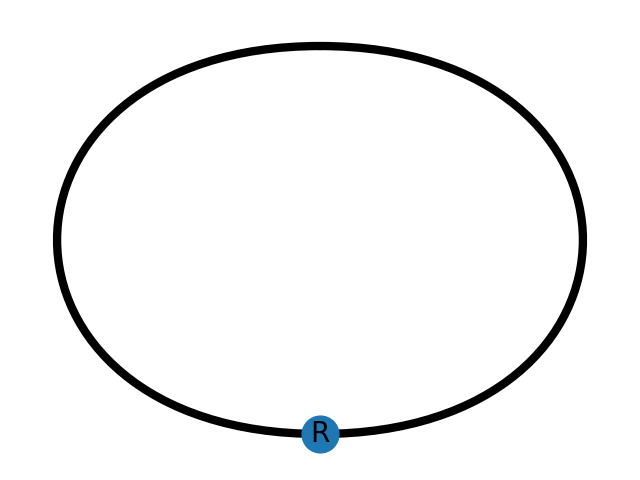

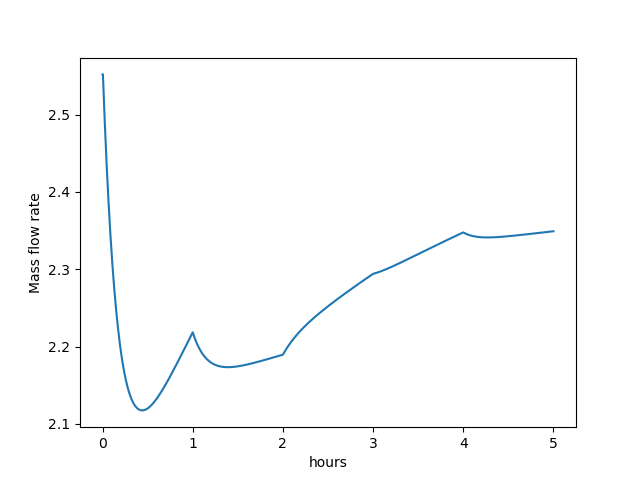

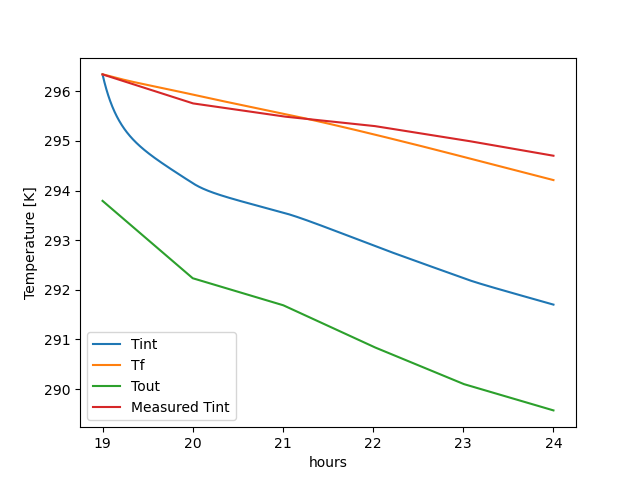

In [29]:

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

### Roof Instead of Walls

#### No Solar Radiation

Text(0, 0.5, 'Temperature [K]')

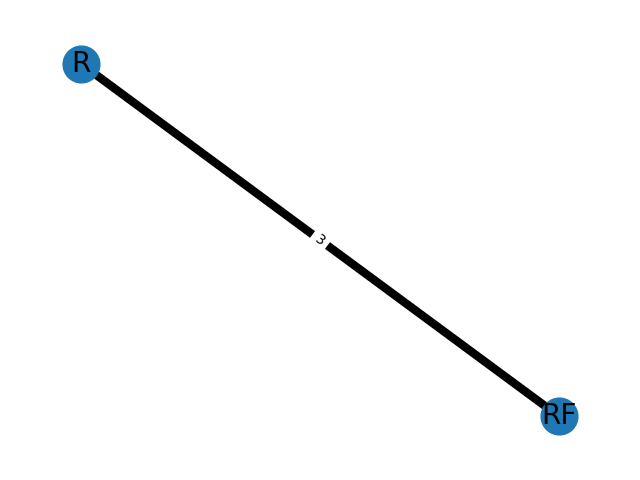

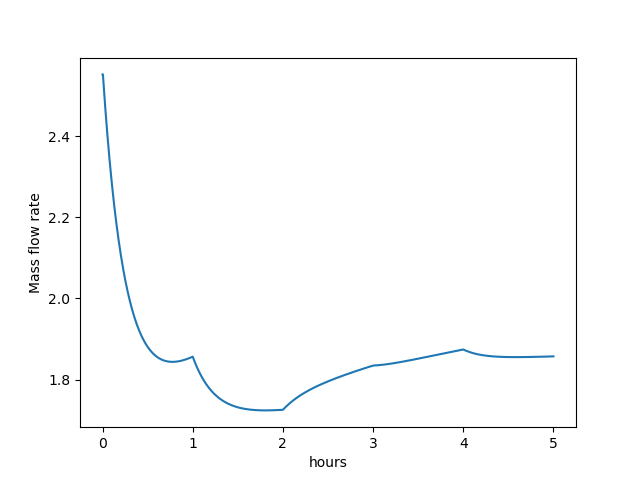

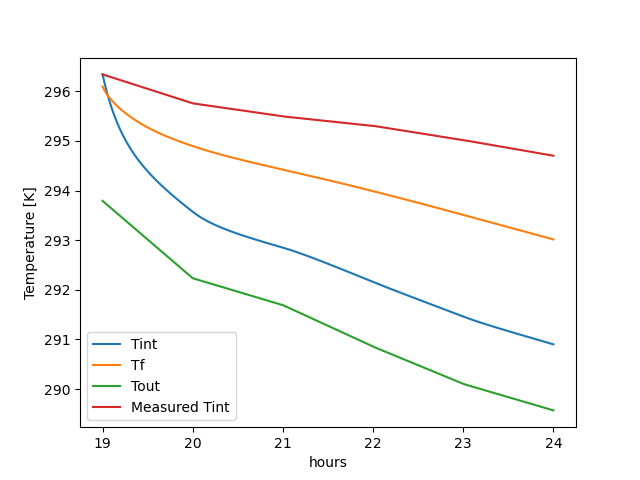

In [30]:

bG = abs.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.draw()

bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

#### Solar Radiation

Text(0, 0.5, 'Radiation [W]')

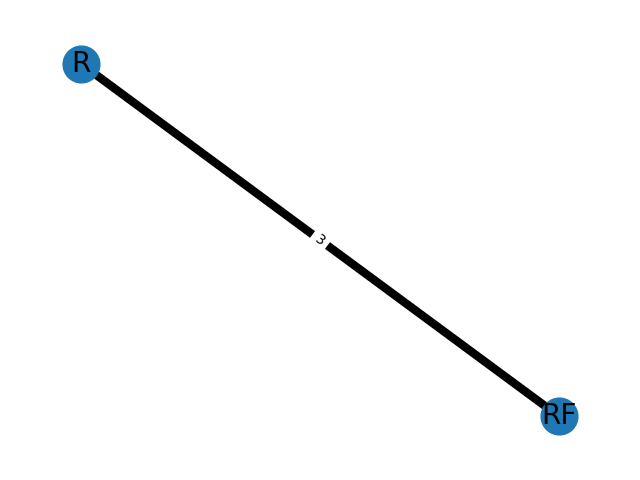

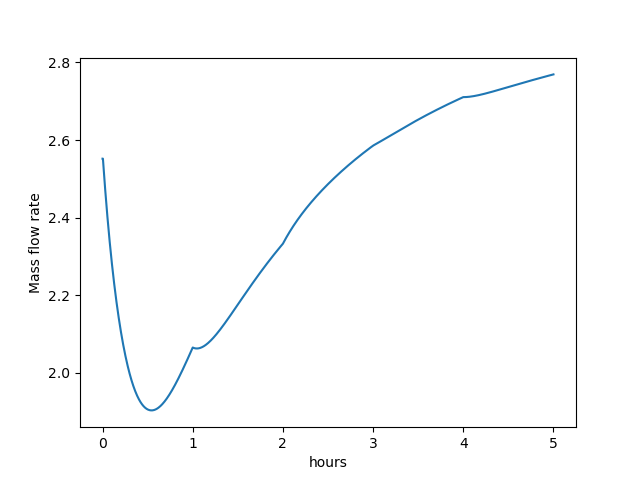

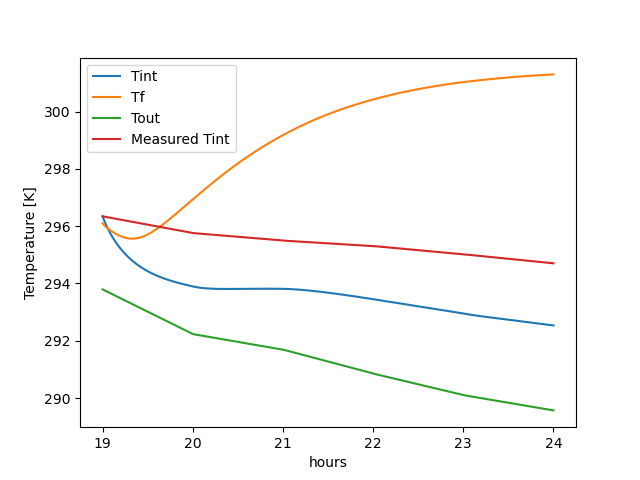

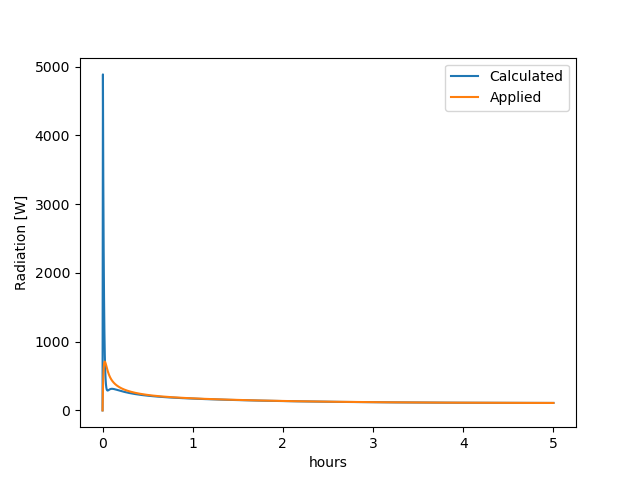

In [31]:

rad_kwargs_RF = {
    "bG": abs.BuildingGraph(
        np.array([
            [0, -1],
            [-1, 0],
        ]),
        [
            ("sun", {}), 
            ("R", {}),
        ]
    ),
}

bG = abs.BuildingGraph(connectivityMatrixOut, roomListOut)
bG.draw()

bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
wall = build_sim.bG.G.edges['R', 'RF']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].back, label='Calculated')
plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].back, label='Applied')
plt.legend()
# plt.ylim([-200, 25])
plt.xlabel('hours')
plt.ylabel('Radiation [W]')

## Simple Multi-Room

/Users/nicholasbachand/Documents/Research/InteriorModeling/abstractions.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


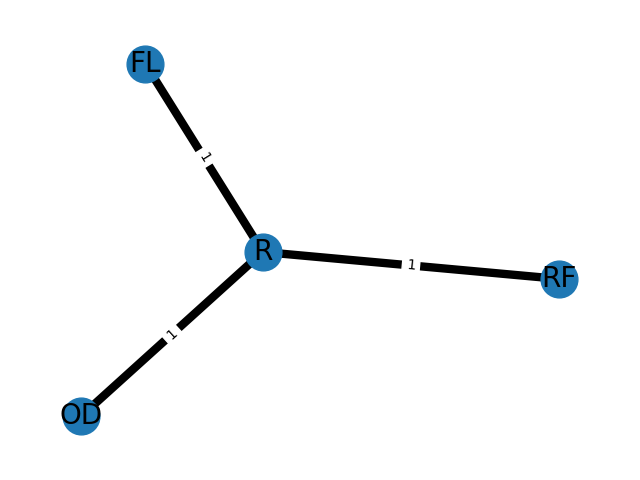

In [32]:
sim_kwargs["Tfloor"] = T_start
# vent_kwargs["ventType"] = None

roomList = [
    ("R", {}), 
    ("FL", {}),
    ("RF", {}),
    ("OD", {}),
    ]

connectivityMatrix = np.array([
    [0, 1, 1, 1],
    [1, 0, 0 ,0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
])

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

### No Radiation

Text(0, 0.5, 'Temperature [K]')

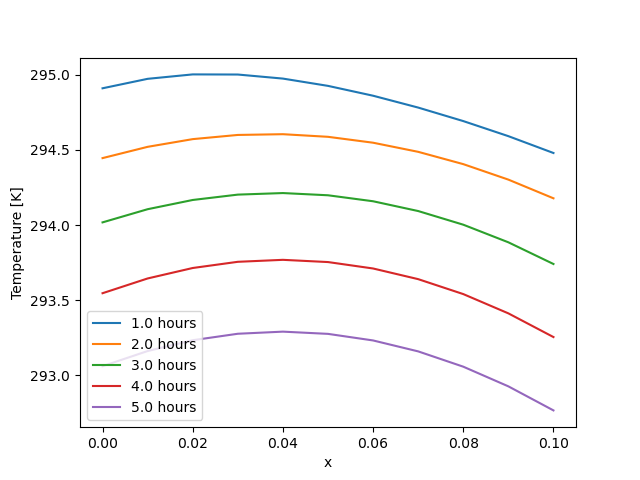

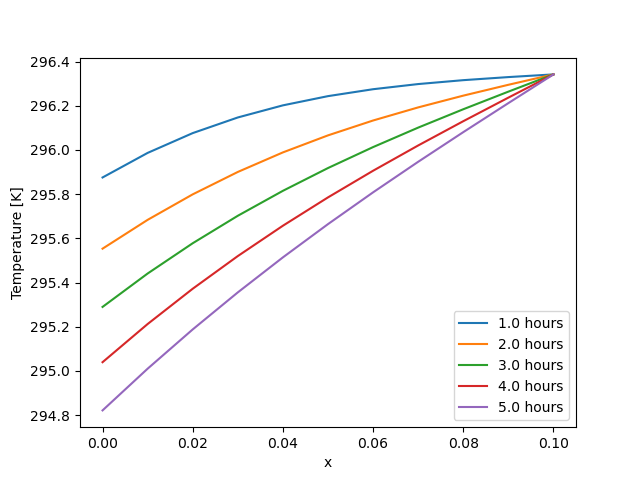

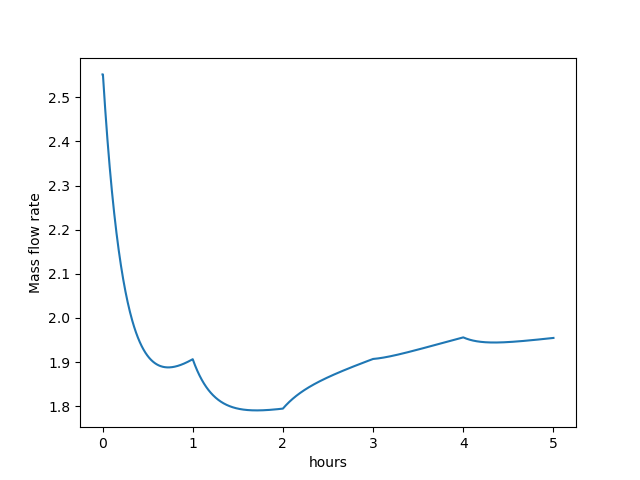

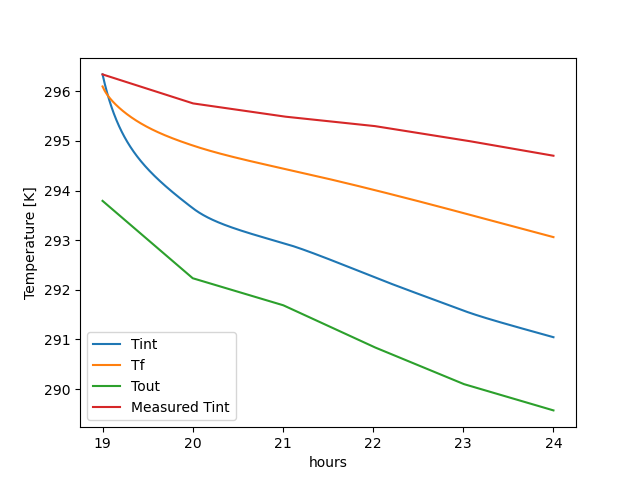

In [33]:
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
T_profs_FL = build_sim.bG.G.edges['R', 'FL']['T_profs']
floor = build_sim.bG.G.edges['R', 'FL']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(floor.x, T_profs_FL[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')


plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

### Radiation

#### Internal Only

Text(0, 0.5, 'Temperature [K]')

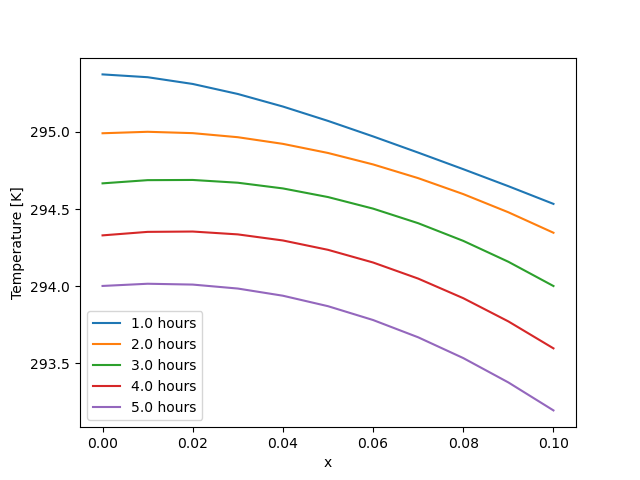

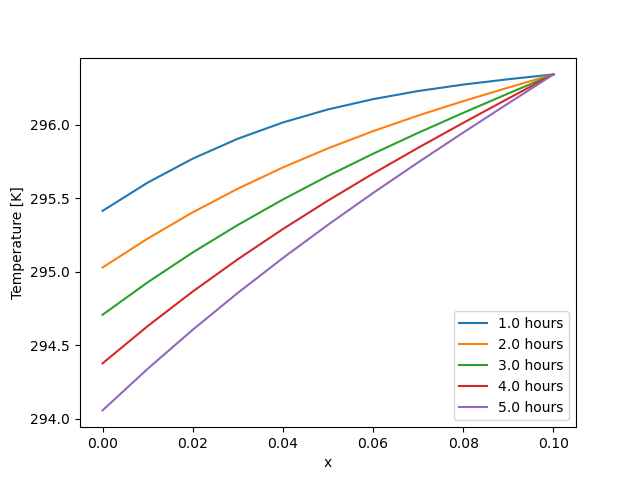

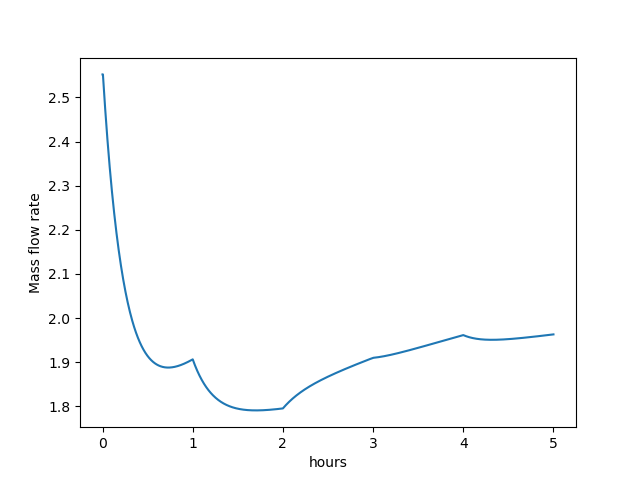

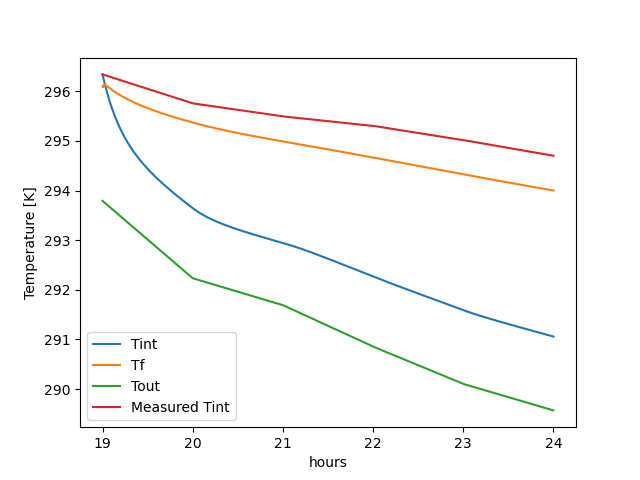

In [34]:
rad_kwargs_R = {
    "bG": abs.BuildingGraph(
        np.array([
            [0, 3],
            [3, 0],
        ]),
        [
            ("RF", {}), 
            ("FL", {}),
        ]
    ),
}

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_R}, nodes=["R"])

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'RF']['T_profs']
T_profs_FL = build_sim.bG.G.edges['R', 'FL']['T_profs']
floor = build_sim.bG.G.edges['R', 'FL']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    h = (h - 48)/4
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(floor.x, T_profs_FL[:, i], label=f'{h % 24} hours')
plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')


plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

In [ ]:
rad_kwargs_RF = {
    "bG": abs.BuildingGraph(
        np.array([
            [0, -1],
            [-1, 0],
        ]),
        [
            ("sun", {}), 
            ("R", {}),
        ]
    ),
}

## My Building

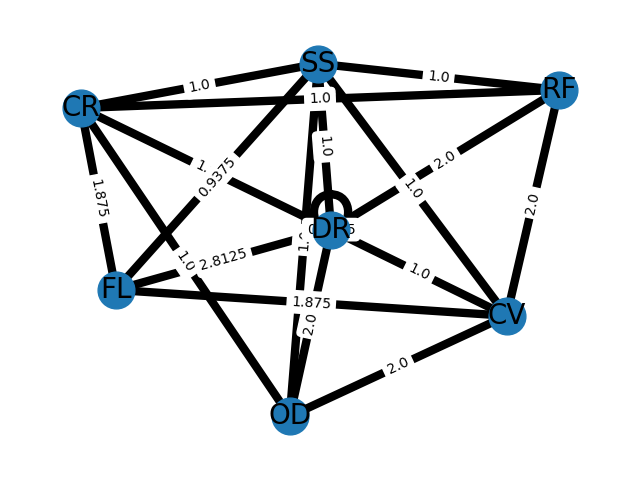

In [14]:
wW = 1- .25**2 #window-wall area
dW = 1 - .25*.75 #door-wall area
roomList = [
    ("CR", {}), 
    ("SS", {}), 
    ("DR", {}), 
    ("CV", {}), 
    ("FL", {}),
    ("RF", {}),
    ("OD", {}),
    ]

connectivityMatrix = np.array([
    [0, 1, 1, 0, 2*wW, 1, 1],
    [1, 0, 1 ,1, wW, 1, 1],
    [1, 1, dW, 1, 3*wW, 2, 2],
    [0, 1, 1, 0, 2*wW, 2, 2],
])

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

In [15]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : T_start - 10,
    "radG": None,
    "Tfloor": T_start,
}
wall_kwargs = {"X": 4, "Y": 3}
wall_kwargs_RF = {"X": 4, "Y": 4}

room_kwargs = {
    "T0": T_start,
    "V" : 4**2 * 3, #volume of air
    "Eint" : 0 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "None",
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}
rad_kwargs_RF = {
    "bG": abs.BuildingGraph(
        np.array([
            [0, -1, -1, -1, -1],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
        ]),
        [
            ("sun", {}), 
            ("SS", {}),
            ("DR", {}),
            ("CV", {}),
            ("CR", {}),
        ]
    ),
}

rad_kwargs_FL = {
    "bG": abs.BuildingGraph(
        np.array([
            [0, 3],
            [3, 0],
        ]),
        [
            ("RF", {}), 
            ("FL", {}),
        ]
    ),
}


bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateNodes({"wall_kwargs" :wall_kwargs_RF}, nodes=["RF", "FL"])
bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": abs.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])
bG.updateNodes({"rad_kwargs": rad_kwargs_FL}, nodes=["SS", "DR", "CV", "CR"])

for r in ["CR", "DR"]:
    bG.G.nodes[r]["room_kwargs"]["V"] *= 2

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
# build_sim.run()
# plt.figure()
# for n, d in build_sim.bG.G.nodes(data=True):
#     plt.plot(build_sim.hours, d['Tints'], label=n)
# plt.legend()

# plt.figure()
# for i, j, d in build_sim.bG.G.edges(data=True):
#     plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}')
# plt.legend()

# plt.figure()
# for i, j, d in build_sim.bG.G.edges(data=True):
#     plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}')
# plt.legend()

# plt.figure()
# for i, j, d in build_sim.bG.G.edges(data=True):
#     center = int(len(d['T_profs'][:, 0]) / 2)
#     plt.plot(build_sim.hours, d['T_profs'][center, :], label=f'{i}-{j}')
# plt.legend()

In [16]:
n = connectivityMatrix.shape[0]
interiorRooms = roomList[:n]
interiorRooms = [r[0] for r in interiorRooms]
radKwargs = {
    "solveRooms": interiorRooms,
}
# display(interiorRooms)

foo = abs.Radiation(**radKwargs)
foo.initialize("RF", build_sim.bG.G)
# foo.initialize("DR", build_sim.bG.G)

foo.bG.draw()
for n in foo.bG.G.nodes:
    print(n)

foo.A


Exception: Invalid keyword arguments, expected {'bG'}

In [ ]:
foo.timeStep(solarGain=500)

296.3419973544974
296.3419973544974
296.3419973544974
296.3419973544974


sun           NaN
SS     702.506183
DR     702.506183
CV     702.506183
CR     702.506183
dtype: float64

In [ ]:
foo.b

AttributeError: 'Radiation' object has no attribute 'b'

In [ ]:
view = foo.bG.G['SS']
view
foo.bG.updateEdges({"weight": 69})
view
type(foo.bG.G)

networkx.classes.graph.Graph